In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
#from telemetry_module import *
from copy import deepcopy
import pickle
import matplotlib as mpl
from scipy import interpolate
import time
from scipy.special import expit
from scipy.stats import gaussian_kde
from statsmodels.graphics import tsaplots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import geopandas as gpd
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
from scipy.special import logit, expit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge, Lasso
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, LassoLarsIC

In [4]:
from bayesfilt.telemetry.utils import *
from bayesfilt.filters.utils import get_covariance_ellipse
from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *
from csg_resample_ks import *
data_dir = os.path.join(CSG_DIR, 'raw_data')

In [5]:
%%time
df, variables = get_annotated_telemetry_df()

CPU times: user 31.8 s, sys: 24.5 s, total: 56.3 s
Wall time: 44.3 s


In [6]:
#df['HeadingRateFdSmooth'] = df['HeadingRateFd'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['HeadingRateSmooth'] = df['HeadingRate'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmooth'] = df['AccelerationHor'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmoothAbs'] = df['AccnHorSmooth'].abs()

In [7]:
ibool = (df['Group'].isin(['pa', 'wy']))
ibool = ibool & (df['TrackTimeElapsed'] > max(time_lags))
ibool = ibool & (df['Agl'] < 200) & (df['Agl'] > -50)
ibool = ibool & (df['WindSpeed80m'] > 5.)
ibool = ibool & (df['HeadingRateAbs'] < 20.)
ibool = ibool & (df['HeadingRateFdAbs'] < 20.)
ibool = ibool & (df['VelocityHor'] > 4.)
#ibool = ibool & (df['AccnHorSmoothAbs'] < 10.)
ibool = ibool & (df.isnull().sum(axis=1) == 0)
num_samples = 2000000
dfshort = df[ibool].sample(n=min(num_samples, ibool.sum()-1), axis=0).copy()
print(ibool.sum()*100/df.shape[0], dfshort.shape[0])

19.85318359864799 2000000


In [8]:
df[['Heading','HeadingRate','HeadingRateSmooth', 'HeadingRateFd', 'HeadingRateFdSmooth']].iloc[112000:112020]

,Heading,HeadingRate,HeadingRateSmooth,HeadingRateFd,HeadingRateFdSmooth
112000,17.887070,-0.284546,-0.402775,-0.000092,-0.325139
112001,16.504530,-0.379303,-0.489153,-1.382538,-0.363626
112002,18.129356,-0.540558,-0.604806,1.624817,-0.555682
112003,16.722172,-0.750702,-0.723506,-1.407196,-0.598175
112004,15.108260,-0.950500,-0.814981,-1.613922,-0.621041
112005,15.108195,-1.079041,-0.849448,-0.000061,-0.622532
112006,13.699971,-1.079895,-0.797455,-1.408234,-1.054849
112007,13.539806,-0.924866,-0.634378,-0.160156,-0.853825
112008,12.146824,-0.620575,-0.350752,-1.392975,-0.607832
112009,10.745420,-0.176605,0.037711,-1.401398,-0.383955


In [9]:
def get_xy_data(idf, xname, yname, nn = 9, qq = 0.5, quant = 0.95):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    if qq > 0:
        ydata = bin_groups['y'].quantile(qq)[:-1]
    else:
        ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(nn, min_periods=1, center=True).mean().bfill().ffill()
    return xgrid, ydata, yerr
def set_size(w=3.75,h=2.5, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## Tailwind and crosswind

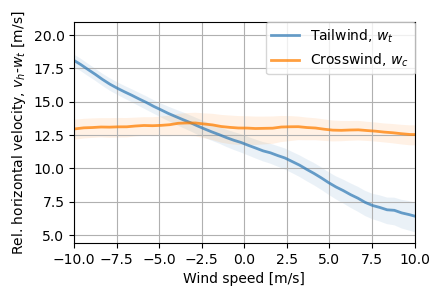

In [10]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'VelocityHorRel'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Rel. horizontal velocity, $v_h$-$w_t$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
# set_size(ax=ax)
ax.set_box_aspect(.65)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'VelocityVer'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
ax.set_box_aspect(.75)
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'HeadingRate'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'AccnHorSmooth'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Rel. horizontal velocity, $v_h$-$w_t$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

## Agl

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'VelocityVer'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_agl_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'VelocityHor'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_agl_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
yname = 'HeadingRate'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Heading rate, $\omega$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_agl_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

## lookahead on vertical vel

In [ ]:
xnames = {
    #40:'OroSmoothD40', 
    '50 m':'OroSmoothD50', 
    #60:'OroSmoothD60',
    #80:'OroSmoothD80', 
    '100 m':'OroSmoothD100', 
    #120:'OroSmoothD120',
    '200 m':'OroSmoothD200', 
    '250 m':'OroSmoothD250', 
    '300 m':'OroSmoothD300',
    '400 m':'OroSmoothD400', 
    '500 m':'OroSmoothD500', 
#     600:'OroSmoothD600',
#     800:'OroSmoothD800', 
    '1 km':'OroSmoothD1000', 
    #2000:'OroSmoothD2000'
}
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
qval = 0.99
nval = 11
mval = 0.5
yname = 'VelocityVerNext'
for i, (idist, xname) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.55, quant=0.99)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.45, quant=0.99)
    #ax.plot(xdata, ydata, '-r',linewidth=2., alpha=0.5, label=xname)
    #ax.plot(xdata, 0.18+ydata*np.power(idist,1/3), '-r',linewidth=2., alpha=0.5, label=xname)
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=1.5, alpha=0.75, label=idist)
#cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[1], ec=None)
#ax.legend()
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,3])
ax.set_ylim([-0.1,0.3])
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=4, title="Distance ahead in the direction of movement", fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('8') 
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_oro_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
thresh_v = 0.8
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
qval = 0.99
nval = 11
mval = 0.5
yname = 'VelocityVerNext'
for i, (idist, xname) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.55, quant=0.99)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.45, quant=0.99)
    #ax.plot(xdata, ydata, '-r',linewidth=2., alpha=0.5, label=xname)
    #ax.plot(xdata, 0.18+ydata*np.power(idist,1/3), '-r',linewidth=2., alpha=0.5, label=xname)
    newy = np.multiply(ydata,np.power(np.multiply(idist,1),1/3))
    ax.plot(xdata, newy, '-b', linewidth=1., alpha=0.75, color=clrs[i], label=idist)
#cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[1], ec=None)
#ax.legend()
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'$v_z d^{1/3}$')
ax.grid(True)
ax.set_xlim([0,3])
ax.set_ylim([-0.5,1])
xx = np.linspace(0,3,50)
yy = -0.1+0.45*expit(2*(xx-thresh_v))*(-thresh_v+xx)
ax.plot(xx, yy, '--k',  linewidth=1.5, label='Modeled')
lg = ax.legend(
    loc=2, borderaxespad=0., ncol=4, title="Distance ahead in the direction of movement", fontsize='small',
    handlelength=1.5, handletextpad=0.5, columnspacing=0.9, fancybox=True
)
lg.get_title().set_fontsize('8')
#ax.plot([thresh_v, thresh_v],[-0.5,1],'--k')
#ax.text(thresh_v, 0.75, r'Threshold updraft, $w_o^{th}$', va='center', ha='center',backgroundcolor='white')
#ax.legend(loc=2, borderaxespad=0., ncol=4, prop={'size': 9}, handlelength=1.5, handletextpad=0.5, columnspacing=0.9)
fig.tight_layout()
set_size(ax=ax)
fig.savefig(os.path.join(FIG_DIR,f'fig_oro_model_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

## lookahead on headingrate

In [ ]:
xnames = {
    #40:'OroSmoothD40', 
    50:'OroSmoothD50', 
    #60:'OroSmoothD60',
    #80:'OroSmoothD80', 
    100:'OroSmoothD100', 
    #120:'OroSmoothD120',
    200:'OroSmoothD200', 
    250:'OroSmoothD250', 
    300:'OroSmoothD300',
    400:'OroSmoothD400', 
    500:'OroSmoothD500', 
#     600:'OroSmoothD600',
#     800:'OroSmoothD800', 
    1000:'OroSmoothD1000', 
    #2000:'OroSmoothD2000'
}
fig, ax = plt.subplots(figsize=(4.5,3))
idf = dfshort
qval = 0.99
nval = 11
mval = 0.5
yname = 'HeadingRateNext'
for i, (idist, xname) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=mval, quant=qval)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.55, quant=0.99)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.45, quant=0.99)
    #ax.plot(xdata, ydata, '-r',linewidth=2., alpha=0.5, label=xname)
    #ax.plot(xdata, 0.18+ydata*np.power(idist,1/3), '-r',linewidth=2., alpha=0.5, label=xname)
    ax.plot(xdata, ydata, '-r', color=clrs[i], linewidth=2, alpha=0.75, label=f'{idist} m')
#cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[1], ec=None)
#ax.legend()
ax.set_xlabel(r'Orographic updraft, $w_o$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$')
ax.grid(True)
ax.set_xlim([0,3])
ax.set_ylim([-0.1,0.3])
ax.legend(loc=2, borderaxespad=0., ncol=3, prop={'size': 9}, markerscale=0.75)
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_oro_{yname.lower()}.png'), dpi=200, bbox_inches='tight')

In [ ]:
# fig, ax = plt.subplots(figsize=(5,3))
# xx = np.linspace(0,3,100)
# thresh_v = 0.8
# yy2 = expit(10*(xx-thresh_v))#np.exp(-1*xx)
# yy1 = expit(-10*(xx-thresh_v))
# yy = 0.0*yy1 + 0.45*yy2*(-thresh_v+xx)
# #ax.plot(xx,yy1,'-r')
# #ax.plot(xx,yy2,'-b')
# ax.plot(xx, yy)
# #ax.set_xlim([0,3])
# ax.grid(True)
# #ax.set_ylim([-0.1,0.3])
# fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort
yname = 'VelocityVer'
xname = 'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([5,25])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_{xname}_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort
yname = 'VelocityVer'
xname = 'HeadingRate'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-15,15])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_{xname}_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
corr_dict = {}
for yname in variables['Pred'] + ['HeadingRateFd', 'AccelerationVer',]:
    corr_dict[yname] = []
    for ilag in time_lags:
        xname = f'{yname}Lag{ilag}'
        icorr = dfshort[xname].corr(dfshort[yname])
        corr_dict[yname].append(icorr)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot([0]+time_lags, [1]+corr_dict['VelocityHor'], '-r', color=clrs[0], label='Horizontal velocity')
ax.plot([0]+time_lags, [1]+corr_dict['VelocityVer'], '-r', color=clrs[1], label='Vertical velocity')
ax.plot([0]+time_lags, [1]+corr_dict['AccelerationVer'], '-r', color=clrs[4], label='Vertical accn')
ax.plot([0]+time_lags, [1]+corr_dict['HeadingRate'], '-r', color=clrs[2], label='Heading rate')
ax.plot([0]+time_lags, [1]+corr_dict['HeadingRateFd'], '-r', color=clrs[3], label='Heading rate fd')
ax.legend(borderaxespad=0., ncol=1)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
#ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
#dfshort['OroSmoothD500S'] = (dfshort['OroSmoothD400'] + dfshort['OroSmoothD500'] +  dfshort['OroSmoothD600'])/3
#dfshort['OroSmoothD1000S'] = (dfshort['OroSmoothD800'] + dfshort['OroSmoothD1000'] +  dfshort['OroSmoothD1200'])/3

dfshort['OroSmoothD50S'] = np.maximum.reduce([
    dfshort['OroSmoothD40'],
    dfshort['OroSmoothD50'],
    dfshort['OroSmoothD60']
])
dfshort['OroSmoothD100S'] = np.maximum.reduce([
    dfshort['OroSmoothD80'], 
    dfshort['OroSmoothD100'],
    dfshort['OroSmoothD120']
])
dfshort['OroSmoothD250S'] = np.maximum.reduce([
    dfshort['OroSmoothD200'],
    dfshort['OroSmoothD250'],
    dfshort['OroSmoothD300']
])
dfshort['OroSmoothD500S'] = np.maximum.reduce([
    dfshort['OroSmoothD400'],
    dfshort['OroSmoothD500'],
    dfshort['OroSmoothD600']
])
dfshort['OroSmoothD1000S'] = np.maximum.reduce([
    dfshort['OroSmoothD800'],
    dfshort['OroSmoothD1000'],
    dfshort['OroSmoothD1200']
])
dfshort['OroSmoothD2000S'] = np.maximum.reduce([
    dfshort['OroSmoothD1600'],
    dfshort['OroSmoothD2000'],
    dfshort['OroSmoothD2400']
])

## Horizontal velocity

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort
yname = 'VelocityHor'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_{xname}_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort
yname = 'HeadingRate'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_{xname}_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
xnames = [
    #'OroSmoothFiftyDiff', 'OroSmoothOnehdDiff', 'OroSmoothTwohdDiff',
    #'OroSmoothFvehdDiff', 'OroSmoothOnekmDiff', 'OroSmoothTwokmDiff'
    'OroSmooth', 'OroSmoothFifty', 'OroSmoothOnehd', 'OroSmoothTwohd',
    'OroSmoothFvehd', #'OroSmoothOnekm', 'OroSmoothTwokm'
]
lbls = ['50 m', '100 m', '250 m', '500 m', '1 km', '2 km']
yname = 'VelocityVerNext'
idf = dfshort
quant = 0.9
for i, xname in enumerate(xnames):
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].median()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(9, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i], linewidth=2., alpha=0.75, label=lbls[i%6])
    #ax.plot(xgrid, ydata+yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
    #ax.plot(xgrid, ydata-yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
#ax.plot(xgrid, np.ones_like(xgrid)*fn(idf[yname]), linestyle='-', color=clrs[i], linewidth=2., alpha=0.75)
ax.legend(borderaxespad=0., ncol=3)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()
#fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
# #fig, ax = plt.subplots(figsize=(5.5,3))
# yname = 'HeadingRateNext'
# idf = dfshort
# quant = 0.9
# zdata={}
# for iangle in ['L15','L30','L60','R15','R30','R60']:
#     xnames = [
#         f'OroSmoothFifty{iangle}Diff', f'OroSmoothOnehd{iangle}Diff', 
#         f'OroSmoothTwohd{iangle}Diff'
#     ]
#     zdata[iangle] = []
#     for i, xname in enumerate(xnames):
#         xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
#         rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
#         rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
#         bin_groups = rdfshortb.groupby(by='bin_col')
#         ydata = bin_groups['y'].mean()[:-1]
#         yerr = bin_groups['y'].std()[:-1]
#         ydata = ydata.rolling(15, min_periods=1, center=True).mean().bfill().ffill()
#         z = np.polyfit(xgrid, ydata, 1)
#         zdata[iangle].append(z[0])
#         #ax.plot(xgrid, ydata, linestyle='-', color=clrs[i%6], linewidth=2., alpha=0.75, label=lbls[i%6])
#         #ax.plot(xgrid, ydata+yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
#         #ax.plot(xgrid, ydata-yerr, linestyle='--', color=clrs[i], linewidth=2., alpha=0.25)
# #ax.plot(xgrid, np.ones_like(xgrid)*fn(idf[yname]), linestyle='-', color=clrs[i], linewidth=2., alpha=0.75)
# # ax.legend(borderaxespad=0., ncol=3)
# # ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
# # ax.set_ylabel('Heading rate, median [deg/s]')
# # ax.grid(True)
# # #ax.set_xlim([-0.1,0.1])
# # #ax.set_ylim([8,12])
# # fig.tight_layout()
# # #fig.savefig(os.path.join(FIG_DIR,f'{yname}_oro2.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3))
yname = 'VelocityVer'
idf = dfshort
quant = 0.9
dists = [
    50,100,200,250,300, 
    400,500,1000,2000
]
for idist in dists:
    xname = f'OroSmoothD{idist}Diff'
    idf[xname] = idf[f'OroSmoothD{idist}'] - 0*idf[f'OroSmooth']
    xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
    rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
    rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
    bin_groups = rdfshortb.groupby(by='bin_col')
    ydata = bin_groups['y'].mean()[:-1]
    yerr = bin_groups['y'].std()[:-1]
    ydata = ydata.rolling(15, min_periods=1, center=True).mean().bfill().ffill()
    ax.plot(xgrid, ydata, linestyle='-', color=clrs[i%6], linewidth=2., alpha=0.75, label=lbls[i%6])
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
#fig, ax = plt.subplots(figsize=(5.5,3))
yname = 'HeadingRate'
idf = dfshort
quant = 0.9
dists = [40,50,60,80,100,120,200,250,300]
zdata = {}
for iangle in ['L15','L30','L60','R15','R30','R60']:
    zdata[iangle] = []
    for idist in dists:
        xname = f'OroSmoothD{idist}{iangle}Diff'
        idf[xname] = idf[f'OroSmoothD{idist}{iangle}'] - idf[f'OroSmoothD{idist}']
        xgrid = np.linspace(*np.quantile(idf[xname], [1 - quant, quant]), 50)
        rdfshortb = pd.DataFrame({'x': idf[xname], 'y': idf[yname]})
        rdfshortb['bin_col'] = np.searchsorted(xgrid, idf[xname])
        bin_groups = rdfshortb.groupby(by='bin_col')
        ydata = bin_groups['y'].median()[:-1]
        yerr = bin_groups['y'].std()[:-1]
        ydata = ydata.rolling(5, min_periods=1, center=True).mean().bfill().ffill()
        z = np.polyfit(xgrid, ydata, 1)
        zdata[iangle].append(z[0])
zdata = {ix:np.array(iy) for ix,iy in zdata.items()}

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dists, zdata['L15'], '-r', color=clrs[0], label = r'$\minus15^o$')
ax.plot(dists, zdata['R15'], '--r', color=clrs[0], label = r'$15^o$')
ax.plot(dists, zdata['L30'], '-r', color=clrs[1], label = r'$\minus30^o$')
ax.plot(dists, zdata['R30'], '--r', color=clrs[1], label = r'$30^o$')
ax.plot(dists, zdata['L60'], '-r', color=clrs[2], label = r'$\minus60^o$')
ax.plot(dists, zdata['R60'], '--r', color=clrs[2], label = r'$60^o$')
ax.legend(borderaxespad=0., ncol=3, loc=4, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlabel('Distance in the direction of movement [m]')
ax.set_ylabel(r'$\omega/\Delta w^o$', rotation='vertical')
ax.set_xlim([40,300])
#ax.set_xlabelticks(['50 m', '100 m'])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_lookahead.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(dists, -zdata['L15']*np.radians(15), '-r', color=clrs[0], label = r'$\minus15^o$')
ax.plot(dists, zdata['R15']*np.radians(15), '--r', color=clrs[0], label = r'$15^o$')
ax.plot(dists, -zdata['L30']*np.radians(30), '-r', color=clrs[1], label = r'$\minus30^o$')
ax.plot(dists, zdata['R30']*np.radians(30), '--r', color=clrs[1], label = r'$30^o$')
ax.plot(dists, -zdata['L60']*np.radians(60), '-r', color=clrs[2], label = r'$\minus60^o$')
ax.plot(dists, zdata['R60']*np.radians(60), '--r', color=clrs[2], label = r'$60^o$')
xx = np.linspace(10,500,50)
yy = 1.2*np.exp(-(xx/100))
ax.plot(xx,yy,'-k',color=clrs[1])
ax.legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handletextpad=0.4)
ax.grid(True)
ax.set_xlabel('Distance in the direction of movement [m]')
ax.set_ylabel(r'$\omega/\Delta w^o$', rotation='vertical')
ax.set_xlim([10,500])
#ax.set_xlabelticks(['50 m', '100 m'])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,'fig_lookahead_mod.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityHorRel'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of relative $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityVer'
xdata, ydata, ystd = get_xy_data(idf, 'WindSupport80m',yname)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Tailwind')
xdata, ydata, ystd = get_xy_data(idf, 'WindLateral80m',yname)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='Crosswind')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_wind_{yname}.png'), dpi=200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
idf = dfshort[dfshort['WindSpeed80m']<100.]
yname = 'VelocityVer'
xdata, ydata, ystd = get_xy_data(idf, 'OroSmooth',yname, nn=13)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75, label='Current')
xdata, ydata, ystd = get_xy_data(idf, 'OroSmoothD50',yname, nn=13)
ax.plot(xdata, ydata, '-b', color=clrs[1], linewidth=2., alpha=0.75, label='50,')
xdata, ydata, ystd = get_xy_data(dfshort, 'WindSpeed80m',yname, nn=13)
#ax.plot(xdata, ydata, '-b', linewidth=2., alpha=0.75, label='Wind')
ax.legend(borderaxespad=0.)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Median of $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,2])
# ax.set_ylim([-0.5,0.5])
fig.tight_layout()
fig.savefig(os.path.join(FIG_DIR,f'fig_oro_{yname}.png'), dpi=200, bbox_inches='tight')